In [1]:
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
  .appName('Yelp! User Analysis')\
  .getOrCreate()

In [3]:
data_clean_folder = "gs://ca4022_yelp_data/data_clean/"


In [ ]:
df_user = spark.read.csv(data_clean_folder + "user.csv", header=True, sep= ",", inferSchema=True)
#df_user.limit(20).show(truncate=False)

In [ ]:
df_user.limit(10).toPandas()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,3.57,22,0,22,3,1,2,11,0,15,...,227,None,14,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...",225,Rafael,553,628,ntlvfPzc8eglqvk92iDIAw,2007-07-06 03:27:11
1,3.84,63,2,63,36,1,4,33,5,37,...,400,"2008,2009,2010,2011,2012,2013",27,"ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...",316,Michelle,564,790,FOBRPlBHa3WPHFB5qYDlVg,2008-04-28 01:29:25
2,3.44,17,1,17,9,0,6,3,1,7,...,103,2010,5,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ...",125,Martin,60,151,zZUnPeh2hEp0WydbAZEOOg,2008-08-28 23:40:05
3,3.08,7,0,7,2,0,1,7,0,14,...,84,2009,6,"iog3Nyg1i4jeumiTVG_BSA, M92xWY2Vr9w0xoH8bPplfQ...",160,John,206,233,QaELAmRcDc5TfJEylaaP8g,2008-09-20 00:08:14
4,4.37,31,1,31,8,1,9,22,31,28,...,512,"2009,2010,2011,2012,2014,2015,2016,2017,2018",78,"3W3ZMSthojCUirKEqAwGNw, eTIbuu23j9tOgmIa9POyLQ...",400,Anne,485,1265,xvu8G900tezTzbbfqmTKvA,2008-08-09 00:30:27
5,2.88,32,7,32,24,2,16,60,9,36,...,155,2007,15,"E-fXXmALnZTPmzzL6rV4cQ, L2g6vS1GDfqLEpiDOFfCkA...",192,Steve,186,642,z5_82komKV3mI4ASGe2-FQ,2007-02-27 07:09:40
6,4.00,0,0,0,0,0,0,2,1,3,...,6,None,0,"1pKOc55fFx09J5t2rPzTxw, HYpE14yYEKSgu3VNVzObHA...",4,Stuart,12,29,ttumcu6hWshk_EJVWrduDg,2010-05-12 16:30:08
7,3.63,623,35,623,483,24,81,193,172,541,...,2878,"2011,2012,2013,2014,2015,2016,2017,2018",137,"c-Dja5bexzEWBufNsHfRrQ, 02HJNyOzzYXvEKVApJb8GQ...",2446,Jennifer,822,4127,f4_MRNHvN-yRn7EA8YWRxg,2011-01-17 00:18:23
8,3.75,0,0,0,0,0,3,3,1,4,...,34,None,4,"YwaKGmRNnSa3R3N4Hf9jLw, v9YpDzYkJarRbzvVIY-63g...",21,Justin,14,68,UYACF30806j2mfbB5vdmJA,2007-07-24 23:55:21
9,4.10,37,5,37,39,3,5,18,5,24,...,426,"2008,2009",31,"tnfVwTpuPlR6W2xEAMiqsg, Bd_16T8Dva27lF5LIrUmcQ...",372,Claire,218,587,QG13XBbgHWydzThRBGJtyw,2007-06-04 00:14:10


### Top Users
Let's aggregate which users have left the most overall reviews on the Yelp! website

In [ ]:
#df_user.groupBy('city').count().sort(col("count").desc()).show(truncate=False)
print(df_user.limit(100000).sort(col("review_count").desc()).limit(10).toPandas()[['user_id', 'name','average_stars', 'yelping_since', 'review_count']])
print('The top 10 Users by number of reviews left')

                  user_id      name  average_stars       yelping_since  \
0  8k3aO-mPeyhbR5HUucA5aA    Victor           3.28 2007-12-08 14:56:45   
1  RtGqdDBvvBCjcu5dUqwfzA     Shila           3.87 2010-10-17 06:35:06   
2  hWDybu_KvYLSdEFzGrniTw     Bruce           3.64 2009-03-08 21:47:44   
3  Hi10sGSZNxQH3NLyWSZ1oA       Fox           3.80 2009-05-26 11:33:58   
4  8RcEwGrFIgkt9WQ35E6SnQ    George           3.49 2009-11-06 22:53:16   
5  nmdkHL2JKFx55T3nq5VziA    Nijole           3.71 2011-11-29 15:50:53   
6  Xwnf20FKuikiHcSpcEbpKQ   Kenneth           3.32 2011-06-10 03:52:07   
7  CxDOIDnH8gp9KXzpBHJYXw  Jennifer           3.33 2009-11-09 20:44:45   
8  HFECrzYDpgbS5EmTBtj2zQ      Eric           3.93 2007-03-28 19:08:35   
9  kS1MQHYwIfD0462PE61IBw       Rob           3.82 2007-08-25 01:33:28   

   review_count  
0         14455  
1         12772  
2         12487  
3         11112  
4          7745  
5          7626  
6          6762  
7          6633  
8          5500  
9    

### Number of Reviews Given by Users
As we can see from the table above, one user has given over 14,000 reviews. Let's take a look at how many reviews users generally upload to Yelp!

Text(0.5, 0.98, 'Number of Reviews Given by Users')

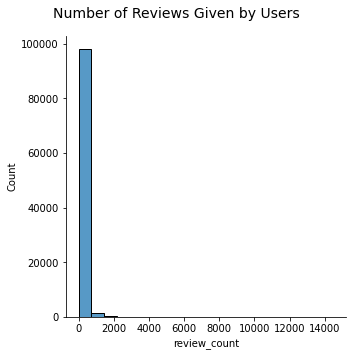

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.displot(df_user.limit(100000).toPandas(),  x = 'review_count', bins = 20)
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle('Number of Reviews Given by Users', fontsize=14)

As expected, the overwhelming majority of the users on the website have written less than 100 reviews. 